In [1]:
import json
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import deepdarksub as dds

result_dir = Path('.') / 'train_results'

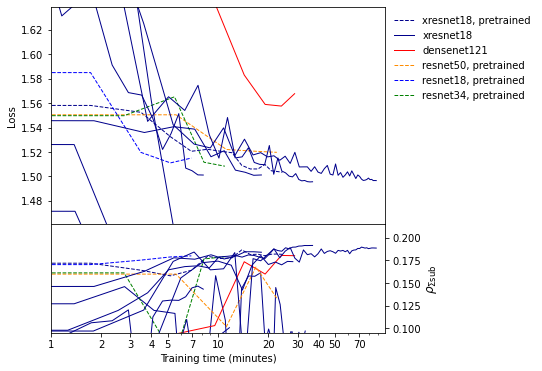

In [2]:
f, axes = plt.subplots(2, 1, figsize=(6,6), sharex=True,
                       gridspec_kw=dict(height_ratios=[2,1]))

results = dict()

for fn in result_dir.glob('*.json'):
    # Different loss, without d_los
#     if str(fn).endswith('xresnet18_0051_d_los_sigma_sub_fromscratch.json'):
#         continue
    with open(fn) as f:
        results[fn.stem] = json.load(f)

order = np.argsort([-r['val_loss'][-1]
                    for r in results.values()
                    if 'val_loss' in r])

results = {k: results[k]
           for k in np.array(list(results.keys()))[order]}


# Time per epoch
sec_per_epoch = dict(
    xresnet18=108,
    resnet18=104,
    resnet34=167,
    resnet50=318,
    densenet121=287,
)

# style_for_arch = {
#     'resnet18': dict(c='b'),
#     'resnet34': dict(c='g'),
#     'resnet50': dict(c='darkorange'),
#     'densenet121': dict(c='r')}
# n_shown = {k:0 for k in style_for_arch}
labels_shown = []
for key, r in results.items():
    if 'val_loss' not in r:
        continue
    if 'epoch_duration' in r:
        mn, sec = r['epoch_duration'].split(':')
        t_ep = 60 * int(mn) + int(sec)
    else:
        t_ep = sec_per_epoch[r['architecture']]

    arch = r['architecture']
    pretrained = r.get('pretrained', 'fromscratch' not in key)
    label = arch + (' I' if pretrained else ' S')

    color = dict(
        xresnet18='darkblue',
        resnet18='b',
        resnet34='g',
        resnet50='darkorange',
        densenet121='red')[arch]
    
    linestyle = '--' if pretrained else '-'
    
    label = arch + (', pretrained' if pretrained else '')
    if label not in labels_shown:
        labels_shown.append(label)
    else:
        label = None
    
    style = dict(color=color, linestyle=linestyle, linewidth=1)
#     akey = arch[1:] if arch.startswith('x') else arch
#     style = dict(linestyle=['-', '--', ':'][n_shown[akey] % 3],
#                  marker='.x*'[n_shown[akey] // 3],
#                  **style_for_arch[akey])
#     n_shown[akey] += 1
    
    n_epochs = r.get('n_epochs', len(r['train_loss']))
    epochs = np.arange(n_epochs)
    t = epochs * t_ep / 60
    
    axes[0].plot(t, r['val_loss'], label=label, **style)
    axes[1].plot(t, r['rho_sub'], **style)
    
plt.sca(axes[0])

plt.ylabel("Loss")
plt.ylim(1.461, 1.639)
legend = plt.legend(loc='upper left',
                    frameon=False,
                    bbox_to_anchor=(1,1))

ax = axes[1]
plt.sca(ax)

plt.ylabel(r"$\rho_{\Sigma\mathrm{sub}}$", fontsize=12)
plt.ylim(0.095, 0.215)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

plt.xlabel("Training time (minutes)")
dds.log_x(1, 100, tick_at=[1, 2, 3, 4, 5, 7])

plt.subplots_adjust(hspace=0)
# plt.savefig('arch_comparison.png', dpi=200, bbox_inches='tight', 
#             bbox_extra_artists=[legend])

TODO: cleanup. Some of these files have different training sets or losses, making the graph messy.

# Old notes

10k training:
  * Resnet18
    * 0,90,180, 270 degree rotations: stagnation after 15 epochs, overtraining after 25.
    * 360 degree rotations: no overtraining in 50 epochs, very slightly better results.
    * Massive substructure set: even with 360-degree rotation, overtraining after 25-30 epochs.
    * Baby dataset:
      * Overtraining after 8 epochs if I don't do rotation! With rotation, no overtraining, and val loss goes lower (1.573->1.515)
      * 20 epochs: No difference for resnet34. Just takes more GPU cycles per epoch.
  * Resnet34: No difference, just takes longer to train
  * DenseNet: even with rotations, overtraining after 25 epochs! Train loss drops to ~1.3 after 40something epochs
  * rhos around 0.124 - 0.116

40k training -- some of it probably with only (0,90,180,270)-degree rotations (oops!):
  * Resnet18: 46 sec/epoch
    * 5-epoch schedule (4.5 minutes): no overtraining. Val loss 1.516; rho = 0.169
      * Repeat: val loss 1.519; rho = 0.172
      * No einstein radius or uncertainty: no OT. Val loss 0.858 (different objective!). rho = 0.161.
      * `**0.2` pixel intensity scaling: val loss 1.520, rho=0.177
      * 1 - data (invert black/white): val loss 1.516, rho=0.166
    * 50-epoch schedule, overtraining around 35-40 epochs; 33 minutes. Val loss at min is 1.511 (aborted at 1.520). rho = 0.132
    
  * ResNet34: 74 sec/epoch
    * 5-epoch schedule (7 minutes): no overtraining. Val loss 1.513; rho = 1.171
    * 10-epoch: Val loss 1.510, rho=0.173
  * DenseNet121: 133 sec/epoch
    * 10-epoch schedule (24 minutes): no overtraining. Val loss 1.509. rho=0.168
    * 50-epoch schedule: minimum val loss 1.507 reached after 25 epochs, then mild overtraining. Aborted at 38 epochs.  

40k training, definitely with free rotations:
  * Resnet18: 
    * 5ep: 1.518, rho=0.168. Repeat: 1.519, rho=0.169
      * `**0.2`: 1.529, rho=0.171
      * `**0.5`: 1.518, rho=0.165
    * 10ep: 1.511, rho=0.170. Repeat: 1.513, rho=0.173
    * 50ep: 1.509, rho=0.169. No noticeable overtraining, though minimum val loss 1.505 reached around epoch 35.
  * DenseNet121. LR find indicates a lower learning rate might be prefered, did not use.
    * 5ep: 1.515, rho=0.172
    
100k training:
  * ResNet18:
    * 5ep: 1.510,

Idea:
  * Do not fix readout noise, instead add it randomly at each epoch during training?look like on the training set? We may also just be finding that the 70 some sources are not sufficiently representative of sources in general to perform well on th